In [2]:
import pandas as pd

# Load the datasets
fraud_data = pd.read_csv('D:/week8&9 data/Fraud_Data.csv')
ip_to_country = pd.read_csv('D:/week8&9 data/IpAddress_to_Country.csv')
credit_card = pd.read_csv('D:/week8&9 data/creditcard.csv')

# Display the first few rows of each dataset
#print(fraud_data.head())
#print(ip_to_country.head())
#print(credit_card.head())

Handle Missing Values

In [3]:
# Check for missing values
print(fraud_data.isnull().sum())
print(ip_to_country.isnull().sum())
print(credit_card.isnull().sum())

# Impute or drop missing values (example: dropping rows with missing values)
fraud_data.dropna(inplace=True)
ip_to_country.dropna(inplace=True)
credit_card.dropna(inplace=True)


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Data Cleaning:  Remove duplicates and correct data types

In [4]:
# Remove duplicates
fraud_data.drop_duplicates(inplace=True)
ip_to_country.drop_duplicates(inplace=True)
credit_card.drop_duplicates(inplace=True)

# Correct data types (example: converting timestamps to datetime)
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])


Exploratory Data Analysis (EDA)

Univariate analysis

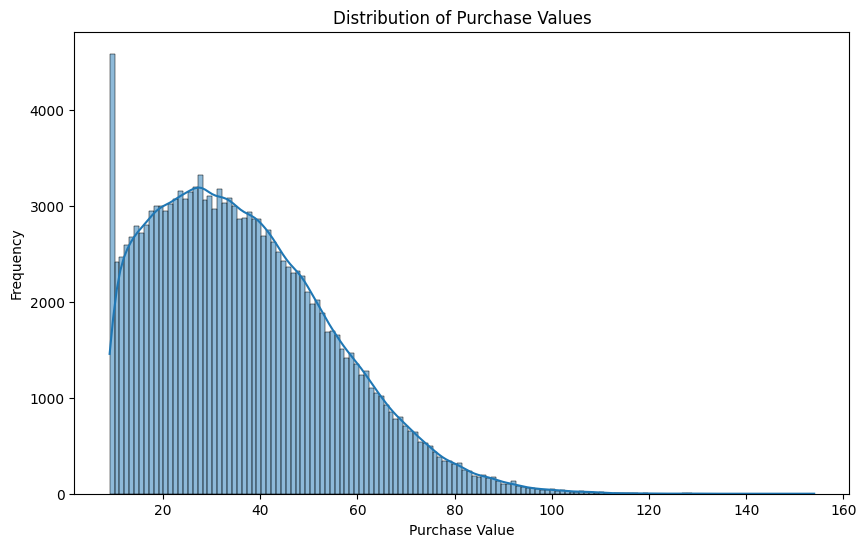

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of purchase values
plt.figure(figsize=(10, 6))
sns.histplot(fraud_data['purchase_value'], kde=True)
plt.title('Distribution of Purchase Values')
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.show()


Bivariate analysis

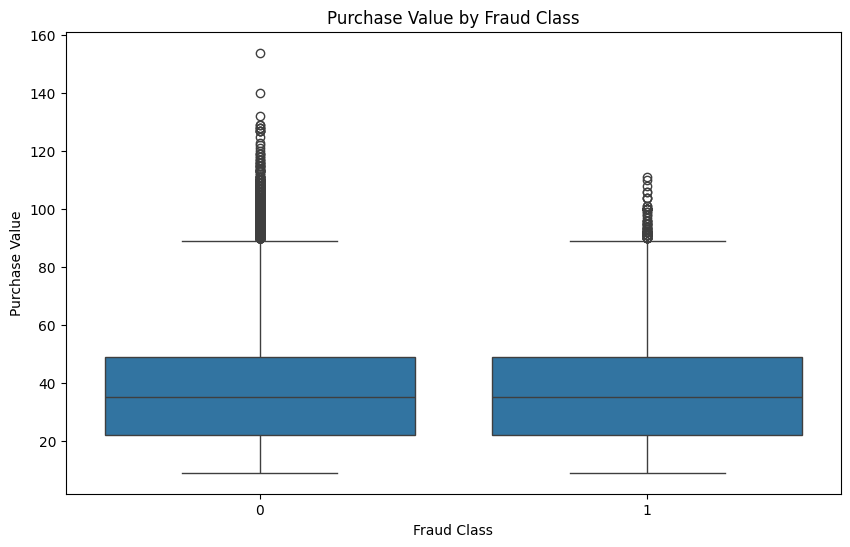

In [6]:
# Relationship between purchase value and fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='purchase_value', data=fraud_data)
plt.title('Purchase Value by Fraud Class')
plt.xlabel('Fraud Class')
plt.ylabel('Purchase Value')
plt.show()

Merge Datasets for Geolocation Analysis

In [14]:
import ipaddress

# Define the conversion function to handle large IP addresses correctly
def ip_to_int(ip):
    return int(ipaddress.ip_address(ip))

# Apply the conversion function to the ip_address column
fraud_data['ip_int'] = fraud_data['ip_address'].apply(lambda x: int(x) if isinstance(x, (int, float)) else ip_to_int(x))

# Convert IP ranges in ip_to_country to integer format correctly
ip_to_country['lower_bound_ip_address'] = ip_to_country['lower_bound_ip_address'].apply(lambda x: int(x) if isinstance(x, (int, float)) else ip_to_int(x))
ip_to_country['upper_bound_ip_address'] = ip_to_country['upper_bound_ip_address'].apply(lambda x: int(x) if isinstance(x, (int, float)) else ip_to_int(x))

# Merge fraud_data with ip_to_country based on IP range
merged_data = pd.merge_asof(
    fraud_data.sort_values('ip_int'),
    ip_to_country.sort_values('lower_bound_ip_address'),
    left_on='ip_int',
    right_on='lower_bound_ip_address',
    direction='forward'
)

# Filter merged_data to only keep rows where ip_int is within the IP range
merged_data = merged_data[
    (merged_data['ip_int'] >= merged_data['lower_bound_ip_address']) & 
    (merged_data['ip_int'] <= merged_data['upper_bound_ip_address'])
]

# Display the first few rows of the merged dataset
print(merged_data.head())


       user_id         signup_time       purchase_time  purchase_value  \
57223   390559 2015-07-09 06:36:13 2015-09-22 04:07:00              51   
58481    34805 2015-08-03 22:17:24 2015-10-27 13:56:57              19   
60792   112145 2015-06-11 06:32:08 2015-09-12 00:14:40              60   

           device_id source browser sex  age    ip_address  class      ip_int  \
57223  SKNQFVNNGMSXY    Ads  Safari   M   24  1.613234e+09      0  1613234176   
58481  JOLAPJZFYHWRB    Ads      IE   F   35  1.648361e+09      0  1648361472   
60792  ELGLONSOXGUFE    Ads  Chrome   F   40  1.729473e+09      0  1729472512   

       lower_bound_ip_address  upper_bound_ip_address        country  
57223            1.613234e+09            1.613365e+09  United States  
58481            1.648361e+09            1.650459e+09  United States  
60792            1.729473e+09            1.729474e+09    Philippines  


Feature Engineering

Transaction Frequency and Velocity:

In [15]:
# Calculate signup-to-purchase time
merged_data['signup_to_purchase_time'] = (merged_data['purchase_time'] - merged_data['signup_time']).dt.total_seconds()

Time-Based Features

In [16]:
# Extract hour of the day and day of the week from purchase_time
merged_data['hour_of_day'] = merged_data['purchase_time'].dt.hour
merged_data['day_of_week'] = merged_data['purchase_time'].dt.dayofweek

Normalization and Scaling

In [17]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to the purchase_value and signup_to_purchase_time features
merged_data[['purchase_value', 'signup_to_purchase_time']] = scaler.fit_transform(merged_data[['purchase_value', 'signup_to_purchase_time']])


Encode Categorical Features

In [18]:
# Apply one-hot encoding to categorical features
merged_data = pd.get_dummies(merged_data, columns=['source', 'browser', 'sex', 'country'])